# Final project: Time-series data and application to stock markets {-}

This project aims at familiarizing you with time-series data analysis and its application to stock markets. Datasets you will be working on are Nasdaq and Vietnam stock datasets.

### Submission {-}
The structure of submission folder should be organized as follows:

- ./\<StudentID>-project-notebook.ipynb: Jupyter notebook containing source code.
- ./\<StudentID>-project-report.pdf: project report.

The submission folder is named DL4AI-\<StudentID>-project (e.g., DL4AI-2012345-project) and then compressed with the same name.
    
### Evaluation {-}
Project evaluation will be conducted on how you accomplish the assignment requirements. You can refer to the project instruction slide deck for details.

### Deadline {-}
Please visit Canvas for details.

# Library importation

In [57]:
# Load libraries
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta
from tabulate import tabulate

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Utility functions

In [59]:
def filter_recent_data(data, number_of_years):
  # Convert the 'date' column to datetime format
  data['TradingDate'] = pd.to_datetime(data['TradingDate'])

  # Calculate the cutoff date as number_of_years years ago from the current date
  cutoff_date = datetime.now() - timedelta(days=number_of_years * 365)

  # Filter the dataset to include only the data within the last 5 years
  df = data[data['TradingDate'] >= cutoff_date]

  return df

In [60]:
def simple_moving_average_plot(df, window_size_1, window_size_2):
  # Create simple moving average columns
  df[str(window_size_1)+'_SMA'] = df['Close'].rolling(window = window_size_1, min_periods = 1).mean()
  df[str(window_size_2)+'_SMA'] = df['Close'].rolling(window = window_size_2, min_periods = 1).mean()

  # Create a new column 'Signal' such that if window_size_1-day SMA is greater than window_size_2-day SMA then set Signal as 1 else 0.
  df['Signal_SMA'] = 0.0  
  df['Signal_SMA'] = np.where(df[str(window_size_1)+'_SMA'] > df[str(window_size_2)+'_SMA'], 1.0, 0.0) 

  # create a new column 'Position' which is a day-to-day difference of the 'Signal_SMA' column. 
  df['Position_SMA'] = df['Signal_SMA'].diff()

  plt.figure(figsize = (20,10))
  plt.tick_params(axis = 'both', labelsize = 14)
  # plot close price, short-term and long-term moving averages 
  df['Close'].plot(color = 'k', lw = 1, label = 'Close Price')  
  df[str(window_size_1)+'_SMA'].plot(color = 'b', lw = 1, label = str(window_size_1)+'-day SMA') 
  df[str(window_size_2)+'_SMA'].plot(color = 'g', lw = 1, label = str(window_size_2)+'-day SMA') 

  # plot 'buy' signals
  plt.plot(df[df['Position_SMA'] == 1].index, 
          df[str(window_size_1)+'_SMA'][df['Position_SMA'] == 1], 
          '^', markersize = 15, color = 'g', alpha = 0.7, label = 'buy')

  # plot 'sell' signals
  plt.plot(df[df['Position_SMA'] == -1].index, 
          df[str(window_size_1)+'_SMA'][df['Position_SMA'] == -1], 
          'v', markersize = 15, color = 'r', alpha = 0.7, label = 'sell')
  plt.ylabel('Price', fontsize = 15 )
  plt.xlabel('Date', fontsize = 15 )
  plt.title('SMA Crossover chart', fontsize = 20)
  plt.legend()
  plt.grid()
  plt.show()

In [61]:
def exponential_moving_average_plot(df, window_size_1, window_size_2):
  # Create exponential moving average columns
  df[str(window_size_1)+'_EMA'] = df['Close'].ewm(span = window_size_1, adjust = False).mean()
  df[str(window_size_2)+'_EMA'] = df['Close'].ewm(span = window_size_2, adjust = False).mean()

  # Create a new column 'Signal_EMA' such that if 20-day SMA is greater than 50-day SMA then set Signal_EMA as 1 else 0.
  df['Signal_EMA'] = 0.0  
  df['Signal_EMA'] = np.where(df[str(window_size_1)+'_EMA'] > df[str(window_size_2)+'_EMA'], 1.0, 0.0) 

  # create a new column 'Position' which is a day-to-day difference of the 'Signal_EMA' column. 
  df['Position_EMA'] = df['Signal_EMA'].diff()

  plt.figure(figsize = (20,10))
  plt.tick_params(axis = 'both', labelsize = 14)
  # plot close price, short-term and long-term moving averages 
  df['Close'].plot(color = 'k', lw = 1, label = 'Close')  
  df[str(window_size_1)+'_EMA'].plot(color = 'b', lw = 1, label = str(window_size_1)+'-day EMA') 
  df[str(window_size_2)+'_EMA'].plot(color = 'g', lw = 1, label = str(window_size_2)+'-day EMA') 

  # plot 'buy' signals
  plt.plot(df[df['Position_EMA'] == 1].index, 
          df[str(window_size_1)+'_EMA'][df['Position_EMA'] == 1], 
          '^', markersize = 15, color = 'g', alpha = 0.7, label = 'buy')

  # plot 'sell' signals
  plt.plot(df[df['Position_EMA'] == -1].index, 
          df[str(window_size_1)+'_EMA'][df['Position_EMA'] == -1], 
          'v', markersize = 15, color = 'r', alpha = 0.7, label = 'sell')
  plt.ylabel('Price in Rupees', fontsize = 15 )
  plt.xlabel('Date', fontsize = 15 )
  plt.title('EMA Crossover', fontsize = 20)
  plt.legend();
  plt.grid()
  plt.show()

# Load the stock price data of the company

In [62]:
with open ('/content/drive/MyDrive/Final Project DL4AI/VNA-UP~1.CSV') as file:
  data = pd.read_csv(file)
  data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3608 entries, 0 to 3607
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   3608 non-null   int64  
 1   Open         3608 non-null   float64
 2   High         3608 non-null   float64
 3   Low          3608 non-null   float64
 4   Close        3608 non-null   float64
 5   Volume       3608 non-null   int64  
 6   TradingDate  3608 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 197.4+ KB


In [63]:
data.head()

,Unnamed: 0,Open,High,Low,Close,Volume,TradingDate
0,0,38673.0,39384.0,31272.0,31272.0,309380,2008-09-09
1,1,32991.0,33070.0,29708.0,29708.0,223650,2008-09-10
2,2,31412.0,31412.0,28287.0,28287.0,35120,2008-09-11
3,3,29913.0,29913.0,26936.0,26936.0,2480,2008-09-12
4,4,27149.0,31333.0,27149.0,27149.0,484330,2008-09-15


In [64]:
# Filter the closing price data for the period of 5 years
df = filter_recent_data(data, 5)

# Display the filtered dataset
print(df)

      Unnamed: 0     Open     High      Low    Close  Volume TradingDate
2419        2419   1300.0   1300.0   1300.0   1300.0    9305  2018-05-30
2420        2420   1400.0   1400.0   1400.0   1400.0     100  2018-05-31
2421        2421   1300.0   1300.0   1300.0   1300.0    2000  2018-06-01
2422        2422   1300.0   1300.0   1300.0   1300.0       0  2018-06-04
2423        2423   1400.0   1400.0   1400.0   1400.0     100  2018-06-05
...          ...      ...      ...      ...      ...     ...         ...
3603        3603  28000.0  28000.0  28000.0  28000.0    1200  2023-02-22
3604        3604  27900.0  27900.0  27900.0  27900.0     211  2023-02-23
3605        3605  26300.0  26500.0  26200.0  26300.0    6800  2023-02-24
3606        3606  26300.0  26300.0  25300.0  26100.0     667  2023-02-27
3607        3607  25000.0  26900.0  23000.0  24000.0    2900  2023-02-28

[1189 rows x 7 columns]


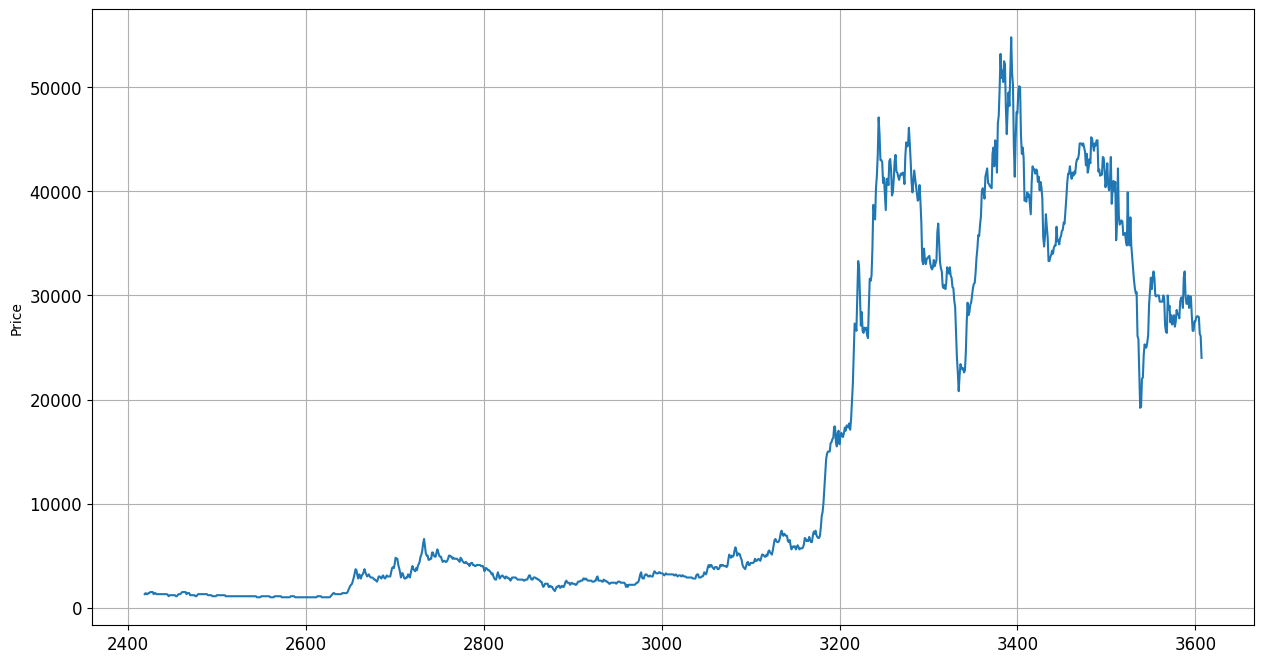

In [65]:
# Observe general price variation of the closing price for the given period
df['Close'].plot(figsize = (15, 8), fontsize = 12)
plt.grid()
plt.ylabel('Price')
plt.show()

# Choose Window Sizes

In [66]:
window_size_1 = 50
window_size_2 = 100

# Simple Moving Average(SMA) Crossover strategy

<ipython-input-60-94cfc7afe433>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(window_size_1)+'_SMA'] = df['Close'].rolling(window = window_size_1, min_periods = 1).mean()
<ipython-input-60-94cfc7afe433>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(window_size_2)+'_SMA'] = df['Close'].rolling(window = window_size_2, min_periods = 1).mean()
<ipython-input-60-94cfc7afe433>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

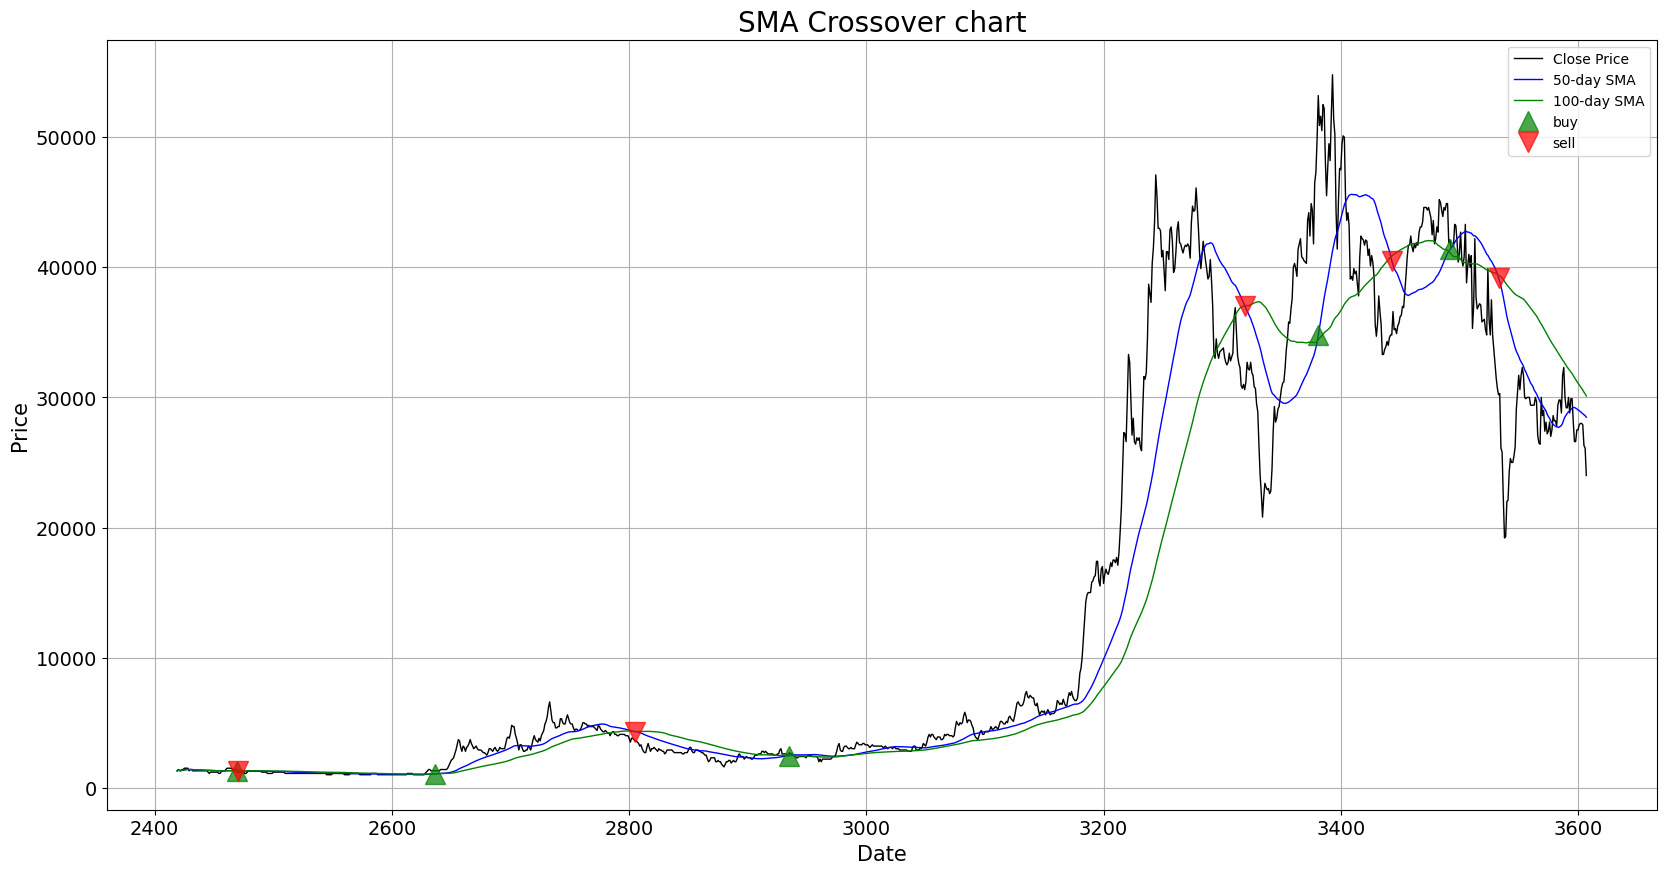

In [67]:
simple_moving_average_plot(df, window_size_1, window_size_2)

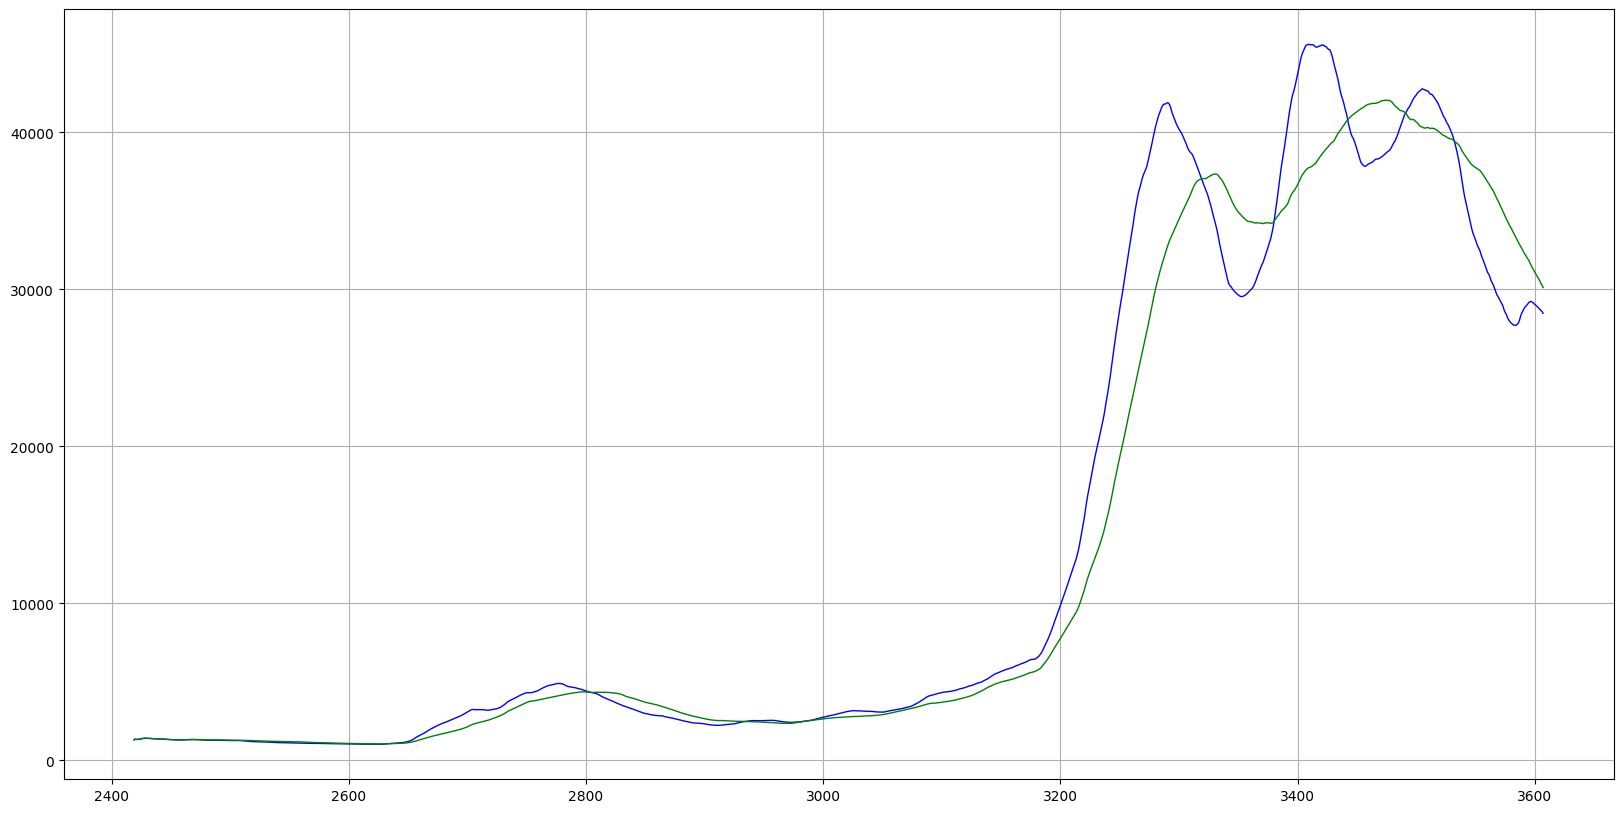

In [68]:
# Plot window_size_1 and window_size_1 simple moving averages 

plt.figure(figsize = (20, 10))
# df['Close'].plot(color = 'k', lw = 1)
df[str(window_size_1)+'_SMA'].plot(color = 'b', lw = 1)
df[str(window_size_2)+'_SMA'].plot(color = 'g', lw = 1)
plt.grid()
plt.show()

In [69]:
# Summarize the results in tabular form
df_new = df[(df['Position_SMA'] == 1) | (df['Position_SMA'] == -1)]
df_new['Position_SMA'] = df_new['Position_SMA'].apply(lambda x: 'Buy' if x == 1 else 'Sell')
print(tabulate(df_new, headers = 'keys', tablefmt = 'psql'))

+------+--------------+--------+--------+-------+---------+----------+---------------------+----------+-----------+--------------+----------------+
|      |   Unnamed: 0 |   Open |   High |   Low |   Close |   Volume | TradingDate         |   50_SMA |   100_SMA |   Signal_SMA | Position_SMA   |
|------+--------------+--------+--------+-------+---------+----------+---------------------+----------+-----------+--------------+----------------|
| 2469 |         2469 |   1400 |   1400 |  1400 |    1400 |        0 | 2018-08-08 00:00:00 |     1324 |   1323.53 |            1 | Buy            |
| 2470 |         2470 |   1200 |   1200 |  1200 |    1200 |     3200 | 2018-08-09 00:00:00 |     1320 |   1321.15 |            0 | Sell           |
| 2636 |         2636 |   1300 |   1300 |  1300 |    1300 |      100 | 2019-04-10 00:00:00 |     1064 |   1062    |            1 | Buy            |
| 2805 |         2805 |   3700 |   3700 |  3500 |    3600 |    37650 | 2019-12-10 00:00:00 |     4318 |   4321  

<ipython-input-69-66cd5e6c3798>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Position_SMA'] = df_new['Position_SMA'].apply(lambda x: 'Buy' if x == 1 else 'Sell')


# Exponential Moving Average(EMA) Crossover strategy

<ipython-input-61-1b4cfb5c10fe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(window_size_1)+'_EMA'] = df['Close'].ewm(span = window_size_1, adjust = False).mean()
<ipython-input-61-1b4cfb5c10fe>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(window_size_2)+'_EMA'] = df['Close'].ewm(span = window_size_2, adjust = False).mean()
<ipython-input-61-1b4cfb5c10fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

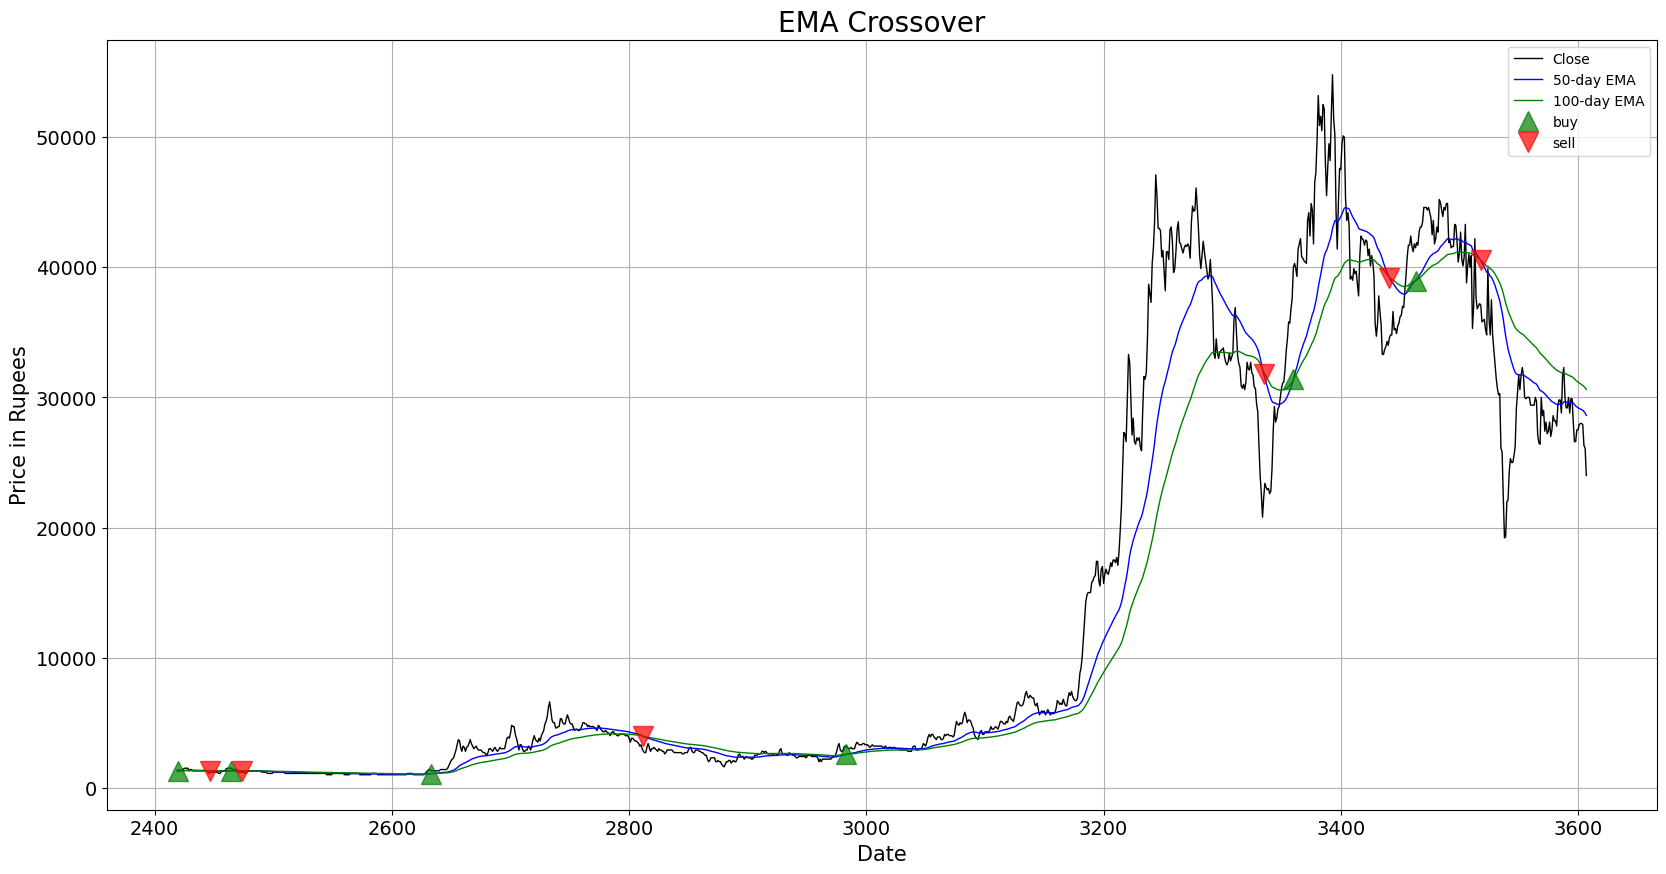

In [70]:
exponential_moving_average_plot(df, window_size_1, window_size_2)

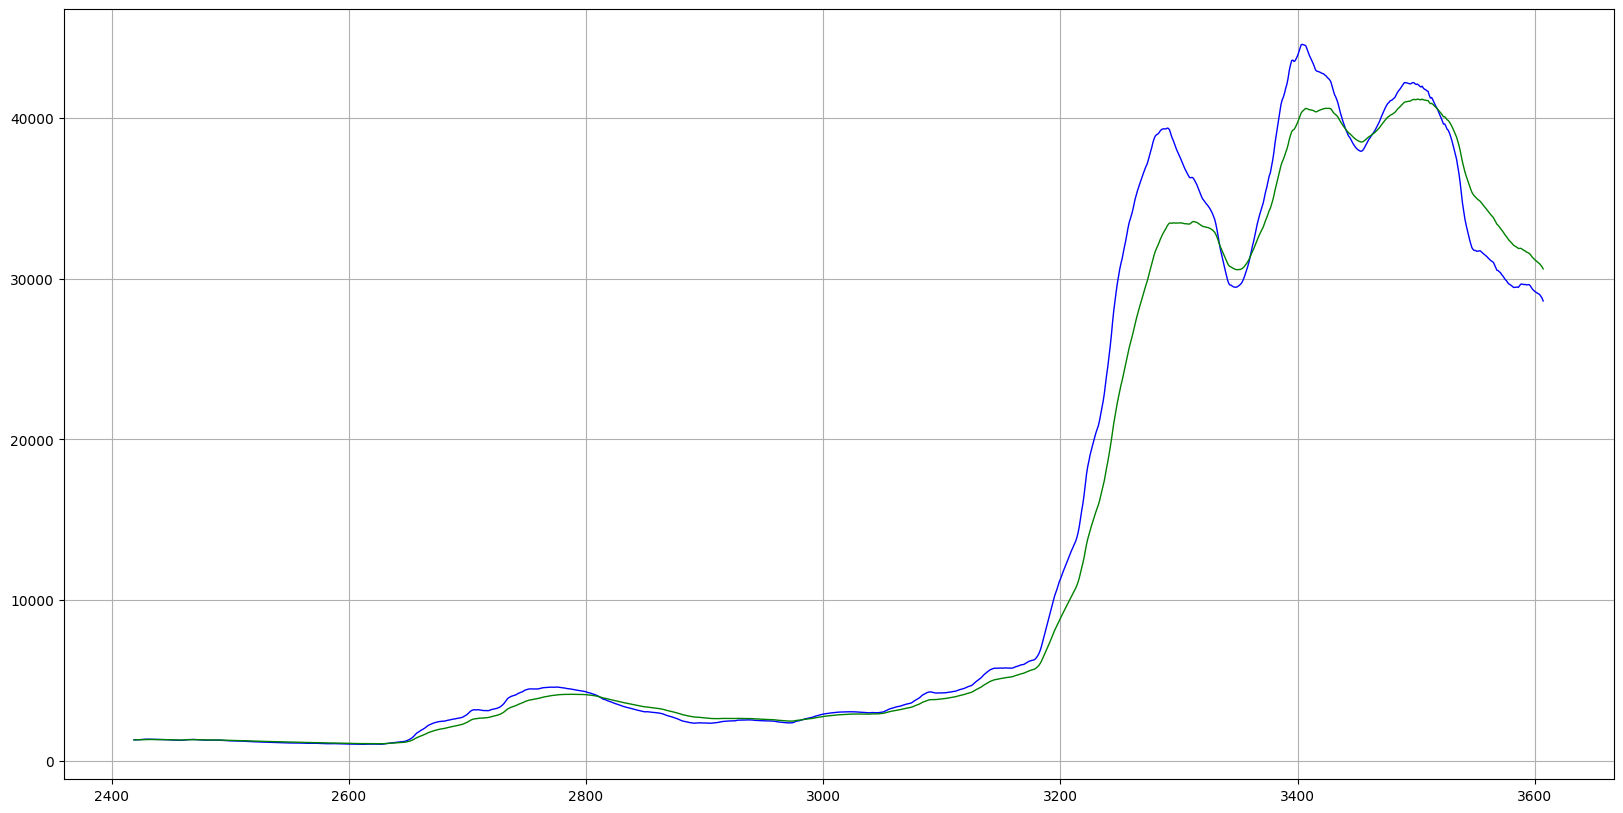

In [71]:
# Plot window_size_1 and window_size_1 exponential moving averages 

plt.figure(figsize = (20, 10))
# df['Close'].plot(color = 'k', lw = 1)
df[str(window_size_1)+'_EMA'].plot(color = 'b', lw = 1)
df[str(window_size_2)+'_EMA'].plot(color = 'g', lw = 1)
plt.grid()
plt.show()

In [72]:
# Summarize the results in tabular form
df_new = df[(df['Position_EMA'] == 1) | (df['Position_EMA'] == -1)]
df_new['Position_EMA'] = df_new['Position_EMA'].apply(lambda x: 'Buy' if x == 1 else 'Sell')
print(tabulate(df_new, headers = 'keys', tablefmt = 'psql'))

+------+--------------+--------+--------+-------+---------+----------+---------------------+----------+-----------+--------------+----------------+----------+-----------+--------------+----------------+
|      |   Unnamed: 0 |   Open |   High |   Low |   Close |   Volume | TradingDate         |   50_SMA |   100_SMA |   Signal_SMA |   Position_SMA |   50_EMA |   100_EMA |   Signal_EMA | Position_EMA   |
|------+--------------+--------+--------+-------+---------+----------+---------------------+----------+-----------+--------------+----------------+----------+-----------+--------------+----------------|
| 2420 |         2420 |   1400 |   1400 |  1400 |    1400 |      100 | 2018-05-31 00:00:00 |  1350    |   1350    |            0 |              0 |  1303.92 |   1301.98 |            1 | Buy            |
| 2447 |         2447 |   1200 |   1200 |  1200 |    1200 |      100 | 2018-07-09 00:00:00 |  1331.03 |   1331.03 |            0 |              0 |  1307.2  |   1309.23 |            0 | Se

<ipython-input-72-f4a36491be20>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Position_EMA'] = df_new['Position_EMA'].apply(lambda x: 'Buy' if x == 1 else 'Sell')
